In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
train_path = "stage1/train"
test_path = "stage1/valid"

In [4]:
IMAGE_SIZE = [128,128]

In [5]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [9]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet

In [10]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 121s 1us/step


In [11]:
x = Flatten()(resnet.output)
prediction = Dense(2, activation='softmax')(x)
model3 = Model(inputs = resnet.inputs, outputs = prediction)
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [ ]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
127/127 [==============================] - 109s 765ms/step - loss: 6.2903 - accuracy: 0.5692 - f1_m: 0.5709 - precision_m: 0.5709 - recall_m: 0.5709 - val_loss: 11498.9551 - val_accuracy: 0.6126 - val_f1_m: 0.6102 - val_precision_m: 0.6102 - val_recall_m: 0.6102
Epoch 2/20
127/127 [==============================] - 96s 753ms/step - loss: 2.8149 - accuracy: 0.5889 - f1_m: 0.5866 - precision_m: 0.5866 - recall_m: 0.5866 - val_loss: 0.6977 - val_accuracy: 0.3874 - val_f1_m: 0.3898 - val_precision_m: 0.3898 - val_recall_m: 0.3898
Epoch 3/20
127/127 [==============================] - 93s 733ms/step - loss: 1.7549 - accuracy: 0.5968 - f1_m: 0.5984 - precision_m: 0.5984 - recall_m: 0.5984 - val_loss: 8.8576 - val_accuracy: 0.6126 - val_f1_m: 0.6142 - val_precision_m: 0.6142 - val_recall_m: 0.6142
Epoch 4/20
127/127 [==============================] - 92s 724ms/step - loss: 0.8546 - accuracy: 0.6206 - f1_m: 0.6220 - precision_m: 0.6220 - recall_m: 0.6220 - val_loss: 92.5675 - val_acc

In [41]:
res_acc = hist3.history["val_accuracy"][19]
res_prec = hist3.history["val_precision_m"][19]
res_rec = hist3.history["val_recall_m"][19]
res_f1 = hist3.history["val_f1_m"][19]

In [48]:
storeResults('ResNet',res_acc,res_prec,res_rec,res_f1)

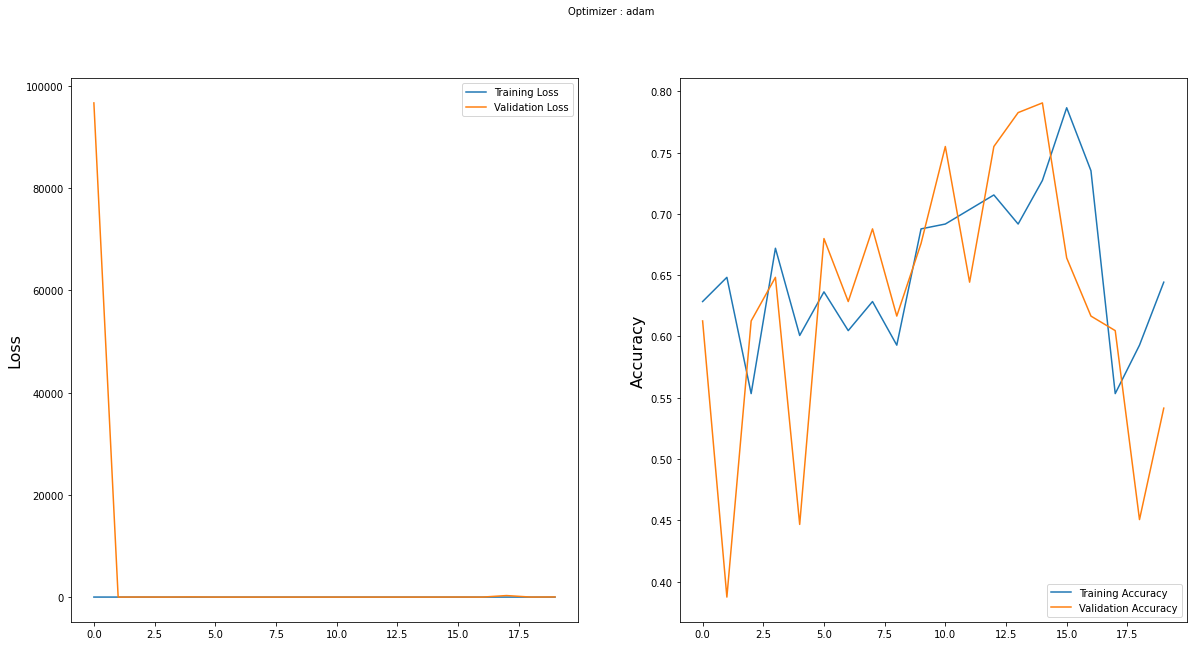

In [14]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(128, 128, 3)))
model4.add(MaxPool2D(strides=2))
model4.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model4.add(MaxPool2D(strides=2))
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dense(84, activation='relu'))
model4.add(Dense(2, activation='softmax'))

In [17]:
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [18]:
model4.build()
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11059456  
_________________________________________________________________
dense_2 (Dense)              (None, 84)                2

In [19]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
127/127 [==============================] - 2s 12ms/step - loss: 0.7054 - accuracy: 0.6680 - f1_m: 0.6654 - precision_m: 0.6654 - recall_m: 0.6654 - val_loss: 0.5858 - val_accuracy: 0.6719 - val_f1_m: 0.6732 - val_precision_m: 0.6732 - val_recall_m: 0.6732
Epoch 2/20
127/127 [==============================] - 1s 11ms/step - loss: 0.6585 - accuracy: 0.6957 - f1_m: 0.6969 - precision_m: 0.6969 - recall_m: 0.6969 - val_loss: 0.6059 - val_accuracy: 0.6759 - val_f1_m: 0.6772 - val_precision_m: 0.6772 - val_recall_m: 0.6772
Epoch 3/20
127/127 [==============================] - 1s 11ms/step - loss: 0.6492 - accuracy: 0.7312 - f1_m: 0.7283 - precision_m: 0.7283 - recall_m: 0.7283 - val_loss: 0.5085 - val_accuracy: 0.7668 - val_f1_m: 0.7638 - val_precision_m: 0.7638 - val_recall_m: 0.7638
Epoch 4/20
127/127 [==============================] - 1s 11ms/step - loss: 0.6379 - accuracy: 0.6957 - f1_m: 0.6969 - precision_m: 0.6969 - recall_m: 0.6969 - val_loss: 0.5330 - val_accuracy: 0.7510 

In [43]:
cnn_acc = hist4.history["val_accuracy"][19]
cnn_prec = hist4.history["val_precision_m"][19]
cnn_rec = hist4.history["val_recall_m"][19]
cnn_f1 = hist4.history["val_f1_m"][19]

In [49]:
storeResults('CNN',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

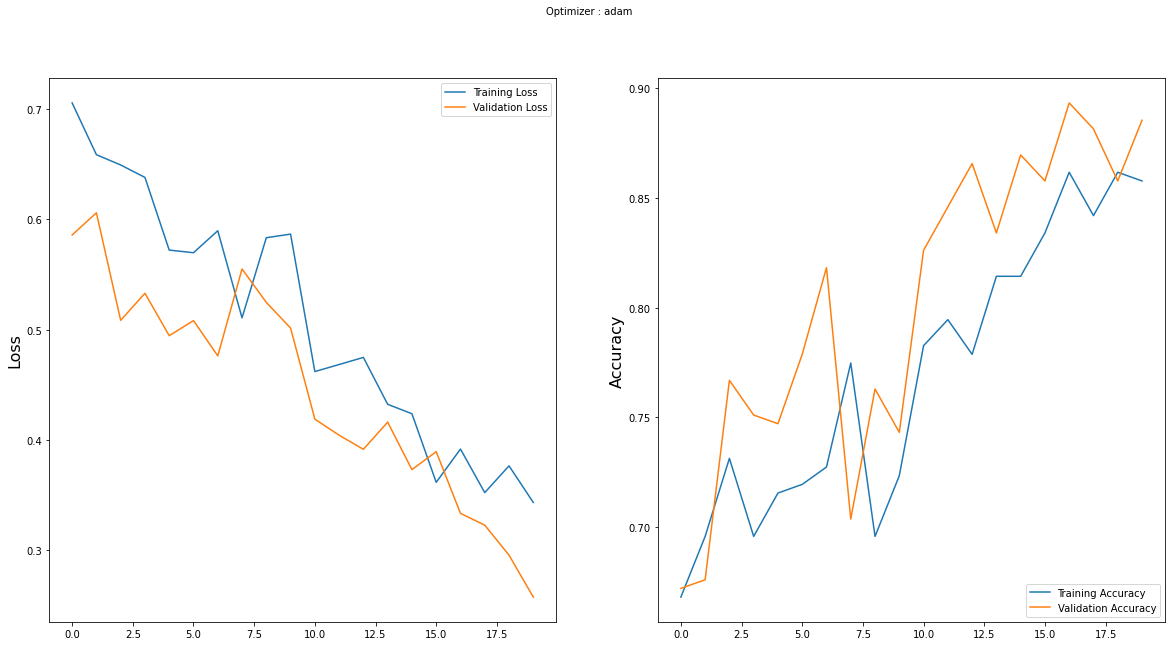

In [21]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet

In [22]:
from tensorflow.keras.applications import DenseNet201

In [23]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [24]:
x1= Flatten()(des201.output)
prediction1 = Dense(2, activation='softmax')(x1)
model7 = Model(inputs = des201.inputs, outputs = prediction1)
model7.summary()
model7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [25]:
hist7 = model7.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
127/127 [==============================] - 34s 168ms/step - loss: 3.8888 - accuracy: 0.6047 - f1_m: 0.6063 - precision_m: 0.6063 - recall_m: 0.6063 - val_loss: 32242.3613 - val_accuracy: 0.6126 - val_f1_m: 0.6142 - val_precision_m: 0.6142 - val_recall_m: 0.6142
Epoch 2/20
127/127 [==============================] - 18s 142ms/step - loss: 3.4989 - accuracy: 0.5573 - f1_m: 0.5551 - precision_m: 0.5551 - recall_m: 0.5551 - val_loss: 66673568.0000 - val_accuracy: 0.6126 - val_f1_m: 0.6142 - val_precision_m: 0.6142 - val_recall_m: 0.6142
Epoch 3/20
127/127 [==============================] - 18s 141ms/step - loss: 4.8300 - accuracy: 0.5534 - f1_m: 0.5512 - precision_m: 0.5512 - recall_m: 0.5512 - val_loss: 923.1702 - val_accuracy: 0.6087 - val_f1_m: 0.6063 - val_precision_m: 0.6063 - val_recall_m: 0.6063
Epoch 4/20
127/127 [==============================] - 18s 143ms/step - loss: 3.2572 - accuracy: 0.5415 - f1_m: 0.5394 - precision_m: 0.5394 - recall_m: 0.5394 - val_loss: 39.3611 -

In [50]:
dense_acc = hist7.history["val_accuracy"][19]
dense_prec = hist7.history["val_precision_m"][19]
dense_rec = hist7.history["val_recall_m"][19]
dense_f1 = hist7.history["val_f1_m"][19]

storeResults('DenseNet',dense_acc,dense_prec,dense_rec,dense_f1)

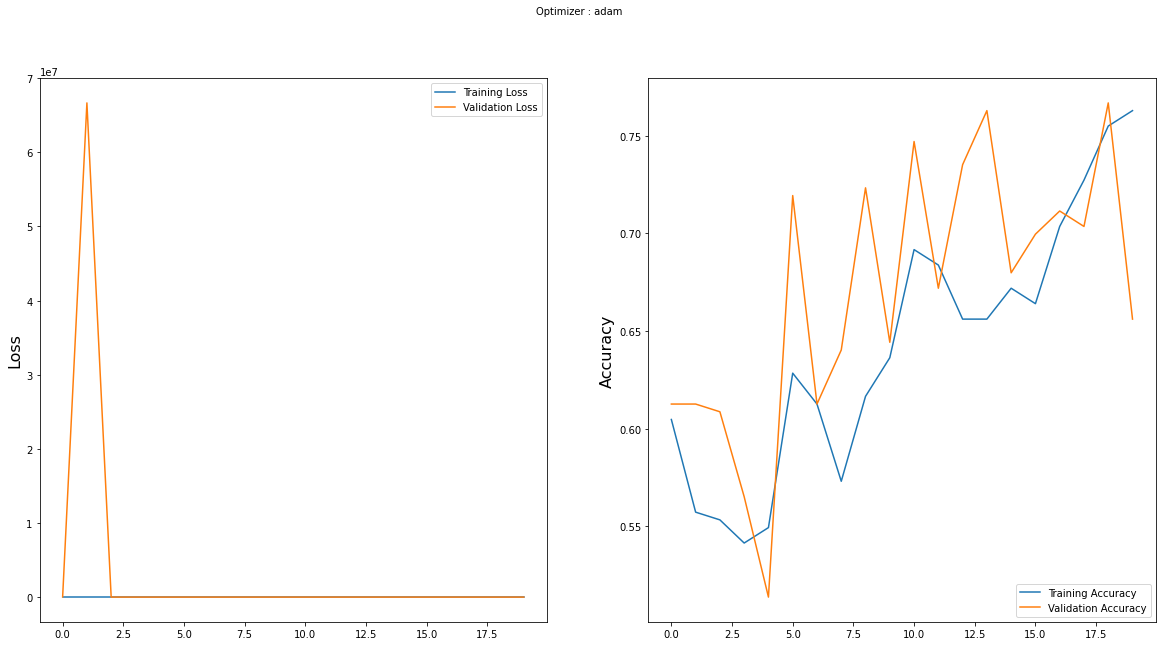

In [27]:
import matplotlib.pyplot as plt

x=hist7
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [10]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head 
model6 = Model(inputs=base.input, outputs=head)

In [11]:
model6.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [13]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
127/127 [==============================] - 4s 35ms/step - loss: 0.1086 - accuracy: 0.9802 - f1_m: 0.9803 - precision_m: 0.9803 - recall_m: 0.9803 - val_loss: 0.0827 - val_accuracy: 0.9881 - val_f1_m: 0.9882 - val_precision_m: 0.9882 - val_recall_m: 0.9882
Epoch 2/20
127/127 [==============================] - 4s 34ms/step - loss: 0.0869 - accuracy: 0.9842 - f1_m: 0.9843 - precision_m: 0.9843 - recall_m: 0.9843 - val_loss: 0.0639 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000uracy: 1.0000 - f1_m: 1.0
Epoch 3/20
127/127 [==============================] - 4s 34ms/step - loss: 0.0700 - accuracy: 0.9881 - f1_m: 0.9882 - precision_m: 0.9882 - recall_m: 0.9882 - val_loss: 0.0594 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/20
127/127 [==============================] - 4s 34ms/step - loss: 0.0813 - accuracy: 0.9723 - f1_m: 0.9724 - precision_m: 0.9724 - recall_m: 0.9724 - val_loss: 0.063

In [15]:
model6.save('model_stage1.h5')

In [51]:
Xce_acc = hist6.history["val_accuracy"][19]
Xce_prec = hist6.history["val_precision_m"][19]
Xce_rec = hist6.history["val_recall_m"][19]
Xce_f1 = hist6.history["val_f1_m"][19]

storeResults('Xception',Xce_acc,Xce_prec,Xce_rec,Xce_f1)

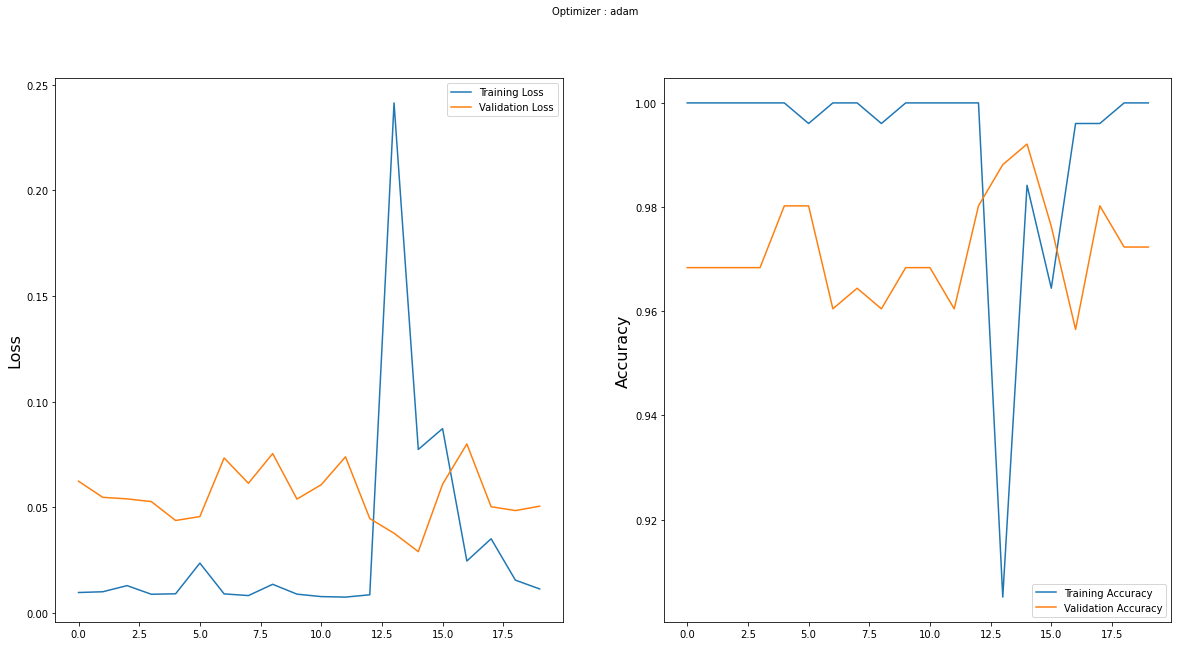

In [52]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [54]:
import pandas as pd
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        
                      })

In [55]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score
0,ResNet,0.542,0.543,0.543,0.543
1,CNN,0.885,0.886,0.886,0.886
2,DenseNet,0.656,0.657,0.657,0.657
3,Xception,0.972,0.972,0.972,0.972


# Graph

In [56]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

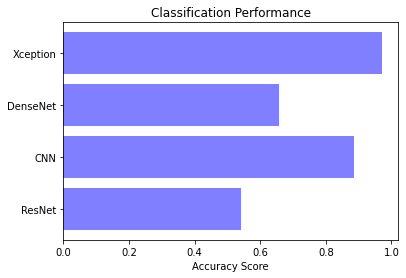

In [57]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

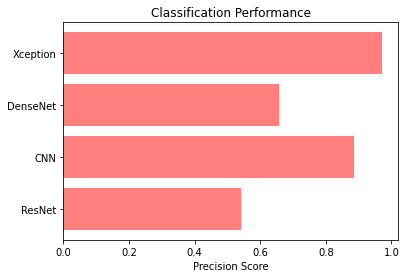

In [58]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

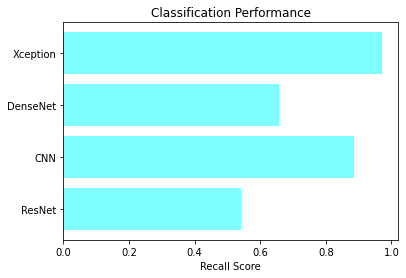

In [59]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='cyan')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 SCore

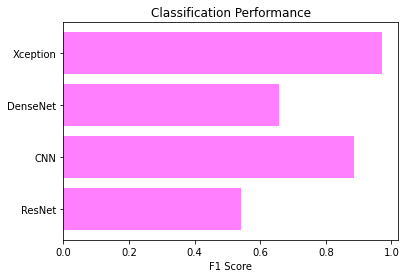

In [60]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='magenta')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()